In [336]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import csv
import pickle
color = sns.color_palette()

In [337]:
RAW_DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/raw_data/'
DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/'
TRAIN_DATA = RAW_DATA_PATH + 'train.csv'
TEST_DATA = RAW_DATA_PATH + 'test.csv'
MACRO_DATA = RAW_DATA_PATH + 'macro.csv'
MODELS_PATH = '/kaggle/dev/ashish/sberbank-russian-housing-market/models/'
SUBMISSIONS_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/submissions/'

In [338]:
missing_df = macro_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df['missing_count_perc'] = (missing_df['missing_count'] / len(macro_df)) * 100.0
missing_df = missing_df.sort_values(['missing_count'], ascending=[False])
missing_df

,column_name,missing_count,missing_count_perc
90,provision_retail_space_modern_sqm,1754,70.611916
89,provision_retail_space_sqm,1753,70.571659
81,modern_education_share,1389,55.917874
82,old_education_build_share,1389,55.917874
92,theaters_viewers_per_1000_cap,1023,41.183575
87,hospital_beds_available_per_cap,1023,41.183575
88,hospital_bed_occupancy_per_year,1023,41.183575
28,grp_growth,1023,41.183575
94,museum_visitis_per_100_cap,1023,41.183575
96,population_reg_sports_share,1023,41.183575


In [355]:
# Prep
train_df = pd.read_csv(TRAIN_DATA, parse_dates=['timestamp'])
macro_df = pd.read_csv(MACRO_DATA, parse_dates=['timestamp'])
test_df = pd.read_csv(TEST_DATA, parse_dates=['timestamp'])

print('Train data', train_df.shape)
print('Test data', test_df.shape)
print('Macro data', macro_df.shape)

# Fix child_on_acc_pre_school column
# macro_df.loc[macro_df['child_on_acc_pre_school'] == '#!', 'child_on_acc_pre_school'] = 0 

print('Merging with macro data..')
# Merge train/test data with macro data
train_macro_df =  pd.merge(train_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(train_macro_df) == len(train_df))
test_macro_df =  pd.merge(test_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(test_macro_df) == len(test_df))

print('Train + Macro data', train_macro_df.shape)
print('Test + Macro data', test_macro_df.shape)

print('Fixing dtypes..')
# Fix incompatible data types between train and test data
train_macro_df['full_sq'] = train_macro_df['full_sq'].astype('float64')
test_macro_df['floor'] = test_macro_df['floor'].astype('float64')
test_macro_df['max_floor'] = test_macro_df['max_floor'].astype('float64')
test_macro_df['material'] = test_macro_df['material'].astype('float64')
test_macro_df['num_room'] = test_macro_df['num_room'].astype('float64')

train_columns = set(train_macro_df.columns)
drop_columns = ['id', 'timestamp', 'price_doc', 'child_on_acc_pre_school']

print('Encoding columns..')
for col in drop_columns:
    if col in train_columns:
        train_columns.remove(col)

for f in train_columns:
    if train_macro_df[f].dtype=='object':
        # print('encoding column:', f, '(original dtype:', train_macro_df[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_macro_df[f].values) | set(test_macro_df[f].values)))
        try:
            train_macro_df[f] = lbl.transform(list(train_macro_df[f].values))
            test_macro_df[f] = lbl.transform(list(test_macro_df[f].values))
        except TypeError as err:
            print('Error encoding column: ', f, err)

def rmsle(y_predicted, y_true):
    y_pred = y_predicted
    y_label = y_true.get_label()
    temp = np.square(np.log(y_pred + 1.0) - np.log(y_label + 1.0))
    error = np.sqrt(np.mean(temp))
    error_std = np.sqrt(np.std(temp))
    print('rmsle:', error, '; std:', error_std)
    return ("rmsle", error)

X = train_macro_df[list(train_columns)]
Y = train_macro_df.price_doc.values

train_X, val_X, train_Y, val_Y = model_selection.train_test_split(X, Y, train_size=0.8, random_state=42)

print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('val_X.shape', val_X.shape)
print('val_Y.shape', val_Y.shape)

Train data (30471, 292)
Test data (7662, 291)
Macro data (2484, 100)
Merging with macro data..
Train + Macro data (30471, 391)
Test + Macro data (7662, 390)
Fixing dtypes..
Encoding columns..
train_X.shape (24376, 387)
train_Y.shape (24376,)
val_X.shape (6095, 387)
val_Y.shape (6095,)


In [356]:
model = xgb.XGBRegressor(max_depth = 10,
                        gamma=0.5,
                        objective="reg:linear",
                        n_estimators=10000,
                        learning_rate=0.005,
                        nthread=12,
                        subsample=0.8,
                        colsample_bytree=0.70,
                        colsample_bylevel=0.70,
                        seed=42,
                        silent=True)

model.fit(train_X, train_Y, eval_set=[(train_X, train_Y), (val_X, val_Y)], verbose=True, eval_metric=rmsle, early_stopping_rounds=50)

model_id = "model-" + str(int(time.time()))
pickle.dump(model, open(MODELS_PATH + model_id + ".xgb", "wb"))

print("Saved model ", model_id)

rmsle: 5.2701 ; std: 2.07173
rmsle: 5.2736 ; std: 2.31494
[0]	validation_0-rmsle:5.2701	validation_1-rmsle:5.2736
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 50 rounds.
rmsle: 4.56869 ; std: 1.84889
rmsle: 4.57001 ; std: 1.98224
[1]	validation_0-rmsle:4.56869	validation_1-rmsle:4.57001
rmsle: 4.16085 ; std: 1.74104
rmsle: 4.16087 ; std: 1.84723
[2]	validation_0-rmsle:4.16085	validation_1-rmsle:4.16087
rmsle: 3.87144 ; std: 1.67379
rmsle: 3.87097 ; std: 1.76547
[3]	validation_0-rmsle:3.87144	validation_1-rmsle:3.87097
rmsle: 3.6518 ; std: 1.61202
rmsle: 3.65411 ; std: 1.69766
[4]	validation_0-rmsle:3.6518	validation_1-rmsle:3.65411
rmsle: 3.47352 ; std: 1.56109
rmsle: 3.47593 ; std: 1.64037
[5]	validation_0-rmsle:3.47352	validation_1-rmsle:3.47593
rmsle: 3.32211 ; std: 1.52066
rmsle: 3.32471 ; std: 1.59741
[6]	validation_0-rmsle:3.32211	validation_1-rmsle:3.32471
rmsle: 3.19242 ; st

rmsle: 1.22841 ; std: 0.735181
rmsle: 1.24263 ; std: 0.77993
[68]	validation_0-rmsle:1.22841	validation_1-rmsle:1.24263
rmsle: 1.21702 ; std: 0.729353
rmsle: 1.23141 ; std: 0.774436
[69]	validation_0-rmsle:1.21702	validation_1-rmsle:1.23141
rmsle: 1.20592 ; std: 0.723402
rmsle: 1.22055 ; std: 0.768919
[70]	validation_0-rmsle:1.20592	validation_1-rmsle:1.22055
rmsle: 1.19498 ; std: 0.717594
rmsle: 1.20985 ; std: 0.76363
[71]	validation_0-rmsle:1.19498	validation_1-rmsle:1.20985
rmsle: 1.18414 ; std: 0.71202
rmsle: 1.19916 ; std: 0.758593
[72]	validation_0-rmsle:1.18414	validation_1-rmsle:1.19917
rmsle: 1.17349 ; std: 0.706476
rmsle: 1.1887 ; std: 0.753544
[73]	validation_0-rmsle:1.17349	validation_1-rmsle:1.1887
rmsle: 1.16312 ; std: 0.700848
rmsle: 1.17859 ; std: 0.748271
[74]	validation_0-rmsle:1.16312	validation_1-rmsle:1.17859
rmsle: 1.15287 ; std: 0.695548
rmsle: 1.16851 ; std: 0.743288
[75]	validation_0-rmsle:1.15287	validation_1-rmsle:1.16851
rmsle: 1.14287 ; std: 0.690022
rmsle:

rmsle: 0.750596 ; std: 0.505026
rmsle: 0.779367 ; std: 0.616346
[135]	validation_0-rmsle:0.750596	validation_1-rmsle:0.779367
rmsle: 0.746236 ; std: 0.504137
rmsle: 0.775264 ; std: 0.616501
[136]	validation_0-rmsle:0.746236	validation_1-rmsle:0.775264
rmsle: 0.741868 ; std: 0.503422
rmsle: 0.771146 ; std: 0.616764
[137]	validation_0-rmsle:0.741868	validation_1-rmsle:0.771146
rmsle: 0.73762 ; std: 0.502649
rmsle: 0.767164 ; std: 0.61704
[138]	validation_0-rmsle:0.73762	validation_1-rmsle:0.767164
rmsle: 0.733434 ; std: 0.502075
rmsle: 0.763233 ; std: 0.617367
[139]	validation_0-rmsle:0.733434	validation_1-rmsle:0.763233
rmsle: 0.729276 ; std: 0.501388
rmsle: 0.759365 ; std: 0.617741
[140]	validation_0-rmsle:0.729276	validation_1-rmsle:0.759365
rmsle: 0.725197 ; std: 0.500874
rmsle: 0.755525 ; std: 0.61817
[141]	validation_0-rmsle:0.725197	validation_1-rmsle:0.755525
rmsle: 0.721162 ; std: 0.500444
rmsle: 0.751728 ; std: 0.618585
[142]	validation_0-rmsle:0.721162	validation_1-rmsle:0.751

rmsle: 0.549202 ; std: 0.536884
rmsle: 0.593605 ; std: 0.674568
[201]	validation_0-rmsle:0.549202	validation_1-rmsle:0.593605
rmsle: 0.547139 ; std: 0.537927
rmsle: 0.591753 ; std: 0.67566
[202]	validation_0-rmsle:0.547139	validation_1-rmsle:0.591753
rmsle: 0.545148 ; std: 0.539044
rmsle: 0.589941 ; std: 0.676763
[203]	validation_0-rmsle:0.545148	validation_1-rmsle:0.589941
rmsle: 0.543164 ; std: 0.540026
rmsle: 0.588187 ; std: 0.677803
[204]	validation_0-rmsle:0.543164	validation_1-rmsle:0.588187
rmsle: 0.541199 ; std: 0.540967
rmsle: 0.586435 ; std: 0.678886
[205]	validation_0-rmsle:0.541199	validation_1-rmsle:0.586435
rmsle: 0.539277 ; std: 0.542098
rmsle: 0.584698 ; std: 0.679964
[206]	validation_0-rmsle:0.539277	validation_1-rmsle:0.584698
rmsle: 0.537333 ; std: 0.543242
rmsle: 0.582898 ; std: 0.68101
[207]	validation_0-rmsle:0.537333	validation_1-rmsle:0.582898
rmsle: 0.535418 ; std: 0.544238
rmsle: 0.581223 ; std: 0.682037
[208]	validation_0-rmsle:0.535418	validation_1-rmsle:0.5

rmsle: 0.453636 ; std: 0.595569
rmsle: 0.51198 ; std: 0.73741
[267]	validation_0-rmsle:0.453636	validation_1-rmsle:0.51198
rmsle: 0.452631 ; std: 0.596236
rmsle: 0.511206 ; std: 0.738217
[268]	validation_0-rmsle:0.452631	validation_1-rmsle:0.511206
rmsle: 0.451683 ; std: 0.596977
rmsle: 0.510444 ; std: 0.739045
[269]	validation_0-rmsle:0.451683	validation_1-rmsle:0.510444
rmsle: 0.45073 ; std: 0.597699
rmsle: 0.509678 ; std: 0.739784
[270]	validation_0-rmsle:0.45073	validation_1-rmsle:0.509678
rmsle: 0.449791 ; std: 0.598422
rmsle: 0.508928 ; std: 0.740545
[271]	validation_0-rmsle:0.449791	validation_1-rmsle:0.508928
rmsle: 0.448856 ; std: 0.599135
rmsle: 0.508186 ; std: 0.741248
[272]	validation_0-rmsle:0.448856	validation_1-rmsle:0.508186
rmsle: 0.447953 ; std: 0.599898
rmsle: 0.507443 ; std: 0.742002
[273]	validation_0-rmsle:0.447953	validation_1-rmsle:0.507443
rmsle: 0.447024 ; std: 0.600525
rmsle: 0.506742 ; std: 0.742751
[274]	validation_0-rmsle:0.447024	validation_1-rmsle:0.5067

rmsle: 0.407334 ; std: 0.632691
rmsle: 0.477179 ; std: 0.780967
[333]	validation_0-rmsle:0.407334	validation_1-rmsle:0.477179
rmsle: 0.406825 ; std: 0.633035
rmsle: 0.476864 ; std: 0.7815
[334]	validation_0-rmsle:0.406825	validation_1-rmsle:0.476864
rmsle: 0.40634 ; std: 0.633393
rmsle: 0.47655 ; std: 0.781996
[335]	validation_0-rmsle:0.40634	validation_1-rmsle:0.47655
rmsle: 0.405875 ; std: 0.633815
rmsle: 0.476219 ; std: 0.782483
[336]	validation_0-rmsle:0.405875	validation_1-rmsle:0.476219
rmsle: 0.405456 ; std: 0.634307
rmsle: 0.475906 ; std: 0.783014
[337]	validation_0-rmsle:0.405456	validation_1-rmsle:0.475906
rmsle: 0.405019 ; std: 0.634755
rmsle: 0.475602 ; std: 0.783528
[338]	validation_0-rmsle:0.405019	validation_1-rmsle:0.475602
rmsle: 0.404592 ; std: 0.635205
rmsle: 0.475296 ; std: 0.784055
[339]	validation_0-rmsle:0.404592	validation_1-rmsle:0.475296
rmsle: 0.404135 ; std: 0.635585
rmsle: 0.474997 ; std: 0.784579
[340]	validation_0-rmsle:0.404135	validation_1-rmsle:0.47499

rmsle: 0.384892 ; std: 0.65471
rmsle: 0.463358 ; std: 0.810304
[399]	validation_0-rmsle:0.384892	validation_1-rmsle:0.463358
rmsle: 0.384659 ; std: 0.65497
rmsle: 0.46325 ; std: 0.810679
[400]	validation_0-rmsle:0.384659	validation_1-rmsle:0.46325
rmsle: 0.38441 ; std: 0.65518
rmsle: 0.463141 ; std: 0.811047
[401]	validation_0-rmsle:0.38441	validation_1-rmsle:0.463141
rmsle: 0.384178 ; std: 0.655415
rmsle: 0.463023 ; std: 0.811381
[402]	validation_0-rmsle:0.384178	validation_1-rmsle:0.463023
rmsle: 0.383932 ; std: 0.655637
rmsle: 0.462912 ; std: 0.81171
[403]	validation_0-rmsle:0.383932	validation_1-rmsle:0.462912
rmsle: 0.383738 ; std: 0.655951
rmsle: 0.462799 ; std: 0.812085
[404]	validation_0-rmsle:0.383738	validation_1-rmsle:0.462799
rmsle: 0.383551 ; std: 0.656241
rmsle: 0.462683 ; std: 0.812449
[405]	validation_0-rmsle:0.383551	validation_1-rmsle:0.462683
rmsle: 0.383327 ; std: 0.656465
rmsle: 0.462578 ; std: 0.812817
[406]	validation_0-rmsle:0.383327	validation_1-rmsle:0.462578


rmsle: 0.373307 ; std: 0.666812
rmsle: 0.458401 ; std: 0.82983
[465]	validation_0-rmsle:0.373307	validation_1-rmsle:0.458401
rmsle: 0.373194 ; std: 0.666964
rmsle: 0.458366 ; std: 0.83007
[466]	validation_0-rmsle:0.373194	validation_1-rmsle:0.458366
rmsle: 0.373045 ; std: 0.667032
rmsle: 0.458316 ; std: 0.830302
[467]	validation_0-rmsle:0.373045	validation_1-rmsle:0.458316
rmsle: 0.372904 ; std: 0.667136
rmsle: 0.458294 ; std: 0.830585
[468]	validation_0-rmsle:0.372904	validation_1-rmsle:0.458294
rmsle: 0.372753 ; std: 0.667203
rmsle: 0.458262 ; std: 0.83085
[469]	validation_0-rmsle:0.372753	validation_1-rmsle:0.458262
rmsle: 0.372659 ; std: 0.667396
rmsle: 0.458235 ; std: 0.831092
[470]	validation_0-rmsle:0.372659	validation_1-rmsle:0.458235
rmsle: 0.372518 ; std: 0.667498
rmsle: 0.458204 ; std: 0.831345
[471]	validation_0-rmsle:0.372518	validation_1-rmsle:0.458204
rmsle: 0.372426 ; std: 0.667668
rmsle: 0.458164 ; std: 0.831581
[472]	validation_0-rmsle:0.372426	validation_1-rmsle:0.45

rmsle: 0.366471 ; std: 0.672502
rmsle: 0.457273 ; std: 0.843566
[531]	validation_0-rmsle:0.366471	validation_1-rmsle:0.457273
rmsle: 0.366405 ; std: 0.672555
rmsle: 0.457272 ; std: 0.843733
[532]	validation_0-rmsle:0.366405	validation_1-rmsle:0.457272
rmsle: 0.366318 ; std: 0.672591
rmsle: 0.457273 ; std: 0.843898
[533]	validation_0-rmsle:0.366318	validation_1-rmsle:0.457273
rmsle: 0.36625 ; std: 0.67268
rmsle: 0.45727 ; std: 0.844065
[534]	validation_0-rmsle:0.36625	validation_1-rmsle:0.45727
rmsle: 0.366144 ; std: 0.672675
rmsle: 0.45727 ; std: 0.844237
[535]	validation_0-rmsle:0.366144	validation_1-rmsle:0.45727
rmsle: 0.366088 ; std: 0.672789
rmsle: 0.457272 ; std: 0.844438
[536]	validation_0-rmsle:0.366088	validation_1-rmsle:0.457272
rmsle: 0.365969 ; std: 0.672763
rmsle: 0.457269 ; std: 0.844589
[537]	validation_0-rmsle:0.365969	validation_1-rmsle:0.457269
rmsle: 0.365906 ; std: 0.672811
rmsle: 0.457278 ; std: 0.844755
[538]	validation_0-rmsle:0.365906	validation_1-rmsle:0.457278

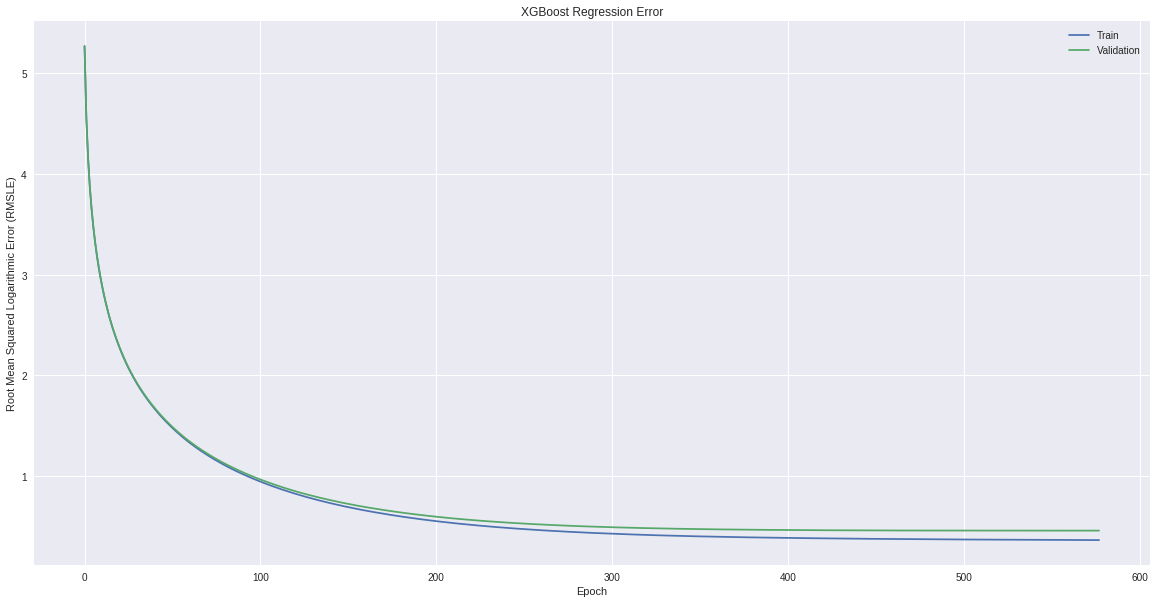

In [357]:
results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Validation')
ax.legend()
plt.ylabel('Root Mean Squared Logarithmic Error (RMSLE)')
plt.xlabel('Epoch')
plt.title('XGBoost Regression Error')
plt.show()

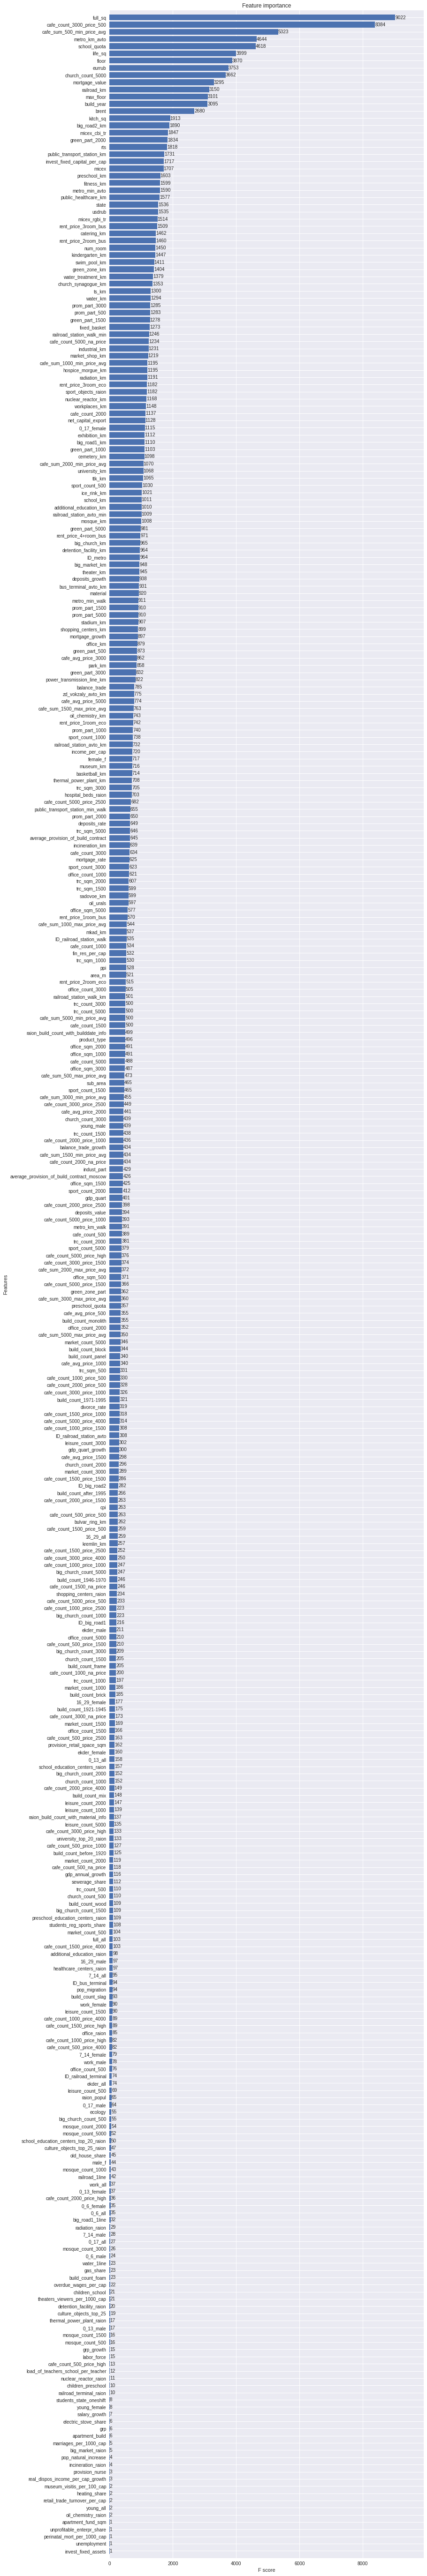

In [358]:
fig, ax = plt.subplots(figsize=(12,100))
xgb.plot_importance(model, height=0.8, ax=ax)

In [359]:
feature_importances_df = pd.DataFrame.from_dict(model.booster().get_score(), orient="index").reset_index()
feature_importances_df.columns = ['feature_name', 'importance_score']
feature_importances_df = feature_importances_df.sort_values(['importance_score'], ascending=[False])
feature_importances_df

,feature_name,importance_score
307,full_sq,9022
6,cafe_count_3000_price_500,8384
36,cafe_sum_500_min_price_avg,5323
9,metro_km_avto,4644
7,school_quota,4618
130,life_sq,3999
61,floor,3870
20,eurrub,3753
8,church_count_5000,3662
17,mortgage_value,3295


In [360]:
macro_importance_df = pd.merge(feature_importances_df, missing_df, left_on='feature_name', right_on='column_name', how='inner')
macro_importance_df

,feature_name,importance_score,column_name,missing_count,missing_count_perc
0,eurrub,3753,eurrub,3,0.120773
1,brent,2680,brent,3,0.120773
2,micex_cbi_tr,1847,micex_cbi_tr,1,0.040258
3,rts,1818,rts,10,0.402576
4,invest_fixed_capital_per_cap,1717,invest_fixed_capital_per_cap,293,11.795491
5,micex,1707,micex,10,0.402576
6,usdrub,1535,usdrub,3,0.120773
7,micex_rgbi_tr,1514,micex_rgbi_tr,10,0.402576
8,rent_price_3room_bus,1509,rent_price_3room_bus,273,10.990338
9,rent_price_2room_bus,1460,rent_price_2room_bus,273,10.990338


In [362]:
# Create test dataframe
test_columns = list(train_columns)
test_columns.append('id')

test_X =  test_macro_df[test_columns]
print("test_X.shape", test_X.shape)

test_X.shape (7662, 388)


In [363]:
# Predict
submission_columns = ['id', 'predicted_price_doc']
model = pickle.load(open(MODELS_PATH + model_id + ".xgb", 'rb'))
filename = SUBMISSIONS_PATH + 'submission-' + str(int(time.time())) + ".csv"
test_X = test_X.assign(predicted_price_doc=model.predict(test_X.loc[:, train_columns]))
predicted_submission_df = test_X[submission_columns]
predicted_submission_df.columns = ['id', 'price_doc']
predicted_submission_df.to_csv(filename, index=False)
print('Generated submission file: {}'.format(filename))

Generated submission file: /kaggle/dev/sberbank-russian-housing-market-data/submissions/submission-1495549633.csv
